<a href="https://colab.research.google.com/github/ccg-esb/MI/blob/main/MI_7_PopulationModel_FluctuatingEvo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook explores the evolutionary dynamics of bacterial populations in environments with fluctuating selective pressures. It uses simulations to model how genetic variation, driven by mobile integrons, interacts with periodic changes in environmental conditions to influence adaptation and survival. The analysis focuses on the impact of fluctuating antibiotic concentrations on the stability of genotypes, evolutionary trajectories, and the emergence of adaptive strategies in microbial populations. This work highlights the role of environmental variability in shaping evolutionary outcomes in complex bacterial systems.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
from google.colab import drive
import importlib
import sys
import matplotlib.colors as mcolors

## Set experimental parameters

In [2]:
base_path = '/content/drive/MyDrive/SYNC_Projects/MI'

initial_resource = 1.0
simulation_time = 24.0
B0=1e6
num_days=30
dilution_factor=0.1

#test_gene_labels=['GC1','GC2', 'X']

#test_gene_labels=['aacA37','aacA45', 'X'] #High polarity
test_gene_labels=['aacA37','smr1', 'X'] #Low polarity


cassettes = ['1', '2', 'X']
num_cassettes=len(cassettes)
initial_genotype_label = '12X'

max_antibiotic_concentration = 1.0
transition_rate=1e-3
p_sos_min = 0.1
c_sos = 0.5
k_sos = 10.0


In [3]:

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

#Data
sheet_url = 'https://docs.google.com/spreadsheets/d/1qJiSMeAn6yq9jhYNUi8X9zgw9gnzgbfuiCVTf6VTH2U/'

# Define the base path in Google Drive and a subdirectory for parameters
pathPARAMS = os.path.join(base_path, 'data/')
dirNameData = os.path.join(pathPARAMS, f"X_{test_gene_labels[0]}_{test_gene_labels[1]}")

pathFIGURES = os.path.join(base_path, 'figures/')
dirNameFigures = os.path.join(pathFIGURES, f"X_{test_gene_labels[0]}_{test_gene_labels[1]}")
os.makedirs(dirNameFigures, exist_ok=True)

if test_gene_labels[0] == 'GC1':  #Theoretical model
    k=0.1

    file_name_strains = f"{dirNameData}/X_{test_gene_labels[0]}_{test_gene_labels[1]}_k{int(k*100)}e-2_strains.pkl"
    file_name_paths = f"{dirNameData}/X_{test_gene_labels[0]}_{test_gene_labels[1]}_k{int(k*100)}e-2_paths.pkl"

    expe_label=f"X_{test_gene_labels[0]}_{test_gene_labels[1]}_k{int(k*100)}e-2"
    file_name_figures = f"{dirNameFigures}/{expe_label}"
else: #From data

    dirNameFigures = os.path.join(pathFIGURES, f"X_{test_gene_labels[0]}_{test_gene_labels[1]}")
    os.makedirs(dirNameFigures, exist_ok=True)

    file_name_strains = f"{dirNameData}/X_{test_gene_labels[0]}_{test_gene_labels[1]}_strains.pkl"
    file_name_paths = f"{dirNameData}/X_{test_gene_labels[0]}_{test_gene_labels[1]}_paths.pkl"

    expe_label=f"X_{test_gene_labels[0]}_{test_gene_labels[1]}"
    file_name_figures = f"{dirNameFigures}/{expe_label}"



pathCODE = os.path.join(base_path, 'code/')
sys.path.append(pathCODE)

import MI_GillespieModel
importlib.reload(MI_GillespieModel)
from MI_GillespieModel import *

print(file_name_strains)
print(file_name_figures)

Mounted at /content/drive
/content/drive/MyDrive/SYNC_Projects/MI/data/X_aacA37_smr1/X_aacA37_smr1_strains.pkl
/content/drive/MyDrive/SYNC_Projects/MI/figures/X_aacA37_smr1/X_aacA37_smr1


## Load Fitness Data

In [4]:


strains = load_strains_parameters(file_name_strains)
strains[0]['color']=[0,0,0]

Strain parameters successfully loaded from: /content/drive/MyDrive/SYNC_Projects/MI/data/X_aacA37_smr1/X_aacA37_smr1_strains.pkl


# Modeling excision/insertion of cassettes

In [5]:

M_exc, M_int, M_dup, list_genotypes = construct_transition_matrices(num_cassettes)
labels_genotypes = [format_genotype_label(g, num_cassettes) for g in list_genotypes]

weights = [0.4, 0.4, 0.2]  # 40% weight to M_exc, 40% to M_int, and 20% to M_dup
M = merge_matrices_with_diagonal_weighted(M_exc, M_int, M_dup, weights=[0.4, 0.4, 0.2])

# Construct the tree
accessibility_tree_labels = construct_accessibility_tree_by_label(
    initial_genotype_label,
    labels_genotypes,
    M
)

# Print the resulting tree
accessible_strains=[]
for genotype, neighbors in accessibility_tree_labels.items():
    print(f"{genotype} -> {neighbors}")


keys_list = list(accessibility_tree_labels.keys())  # Get the list of keys from the dictionary

# Filter strains based on strainID being in keys_list
strains_accessible = [strain for strain in strains if strain['strainID'] in keys_list]
# Filter labels_genotypes to include only those in keys_list
labels_genotypes_accessible = [label for label in labels_genotypes if label in keys_list]

# Print the result
print(labels_genotypes_accessible)

# Crop transition matrices
M_exc_accessible, M_int_accessible = crop_transition_matrices(M_exc, M_int, labels_genotypes, labels_genotypes_accessible)
M_accessible = crop_transition_matrix(M, labels_genotypes, labels_genotypes_accessible)

12X -> ['120', '1X0', '2X0', '12X', '21X', 'X12']
120 -> ['100', '200', '120', '210', '112', '212']
1X0 -> ['100', 'X00', '1X0', 'X10', '11X', 'X1X']
2X0 -> ['200', 'X00', '2X0', 'X20', '22X', 'X2X']
21X -> ['1X0', '210', '2X0', '12X', '21X', 'X21']
X12 -> ['120', 'X10', 'X20', '1X2', '2X1', 'X12']
100 -> ['000', '100']
200 -> ['000', '200']
210 -> ['100', '200', '120', '210', '121', '221']
112 -> ['110', '120', '112', '211']
212 -> ['120', '210', '220', '122', '212', '221']
X00 -> ['000', 'X00']
X10 -> ['100', 'X00', '1X0', 'X10', '1X1', 'XX1']
11X -> ['110', '1X0', '11X', 'X11']
X1X -> ['1X0', 'X10', 'XX0', '1XX', 'X1X', 'XX1']
X20 -> ['200', 'X00', '2X0', 'X20', '2X2', 'XX2']
22X -> ['220', '2X0', '22X', 'X22']
X2X -> ['2X0', 'X20', 'XX0', '2XX', 'X2X', 'XX2']
X21 -> ['210', 'X10', 'X20', '1X2', '2X1', 'X21']
1X2 -> ['120', '1X0', 'X20', '1X2', '21X', 'X12']
2X1 -> ['210', '2X0', 'X10', '12X', '2X1', 'X21']
000 -> ['000']
121 -> ['110', '120', '210', '112', '121', '211']
221 -> ['21

# Evolutionary experiments

In [6]:
def runSimulationVaryingEnvironment(
    M, strains, initial_populations, num_days, antibiotic_concentrations, initial_resource,
    simulation_time, dilution=0.1, transition_rate=0.01, dt=0.1,
    p_sos_min=0.1, c_sos=0.5, k_sos=10.0, max_antibiotic_concentration=1.0, verbose=False,
    extinction_threshold=1e3
):
    """
    Runs a simulation over multiple days with specific strain parameters, using the provided initial populations,
    with varying antibiotic concentrations.

    Parameters:
    strains (list): List of dictionaries for strains with relevant parameters.
    initial_populations (numpy array): Initial population sizes for each strain.
    num_days (int): Number of days to simulate.
    antibiotic_concentrations (list of float): List of antibiotic concentrations for each day.
    initial_resource (float): Shared initial resource concentration.
    simulation_time (float): Duration of each day's simulation.
    dilution (float): Dilution factor applied at the end of each day.
    transition_rate (float): Base rate at which genotype transitions occur.
    dt (float): Time interval for batch updates.
    p_sos_min (float): Minimum reshuffling probability (at zero antibiotic concentration).
    c_sos (float): Midpoint concentration of the sigmoid function for reshuffling probability.
    k_sos (float): Steepness of the sigmoid function.
    max_antibiotic_concentration (float): Maximum antibiotic concentration for SOS induction.
    verbose (bool): If True, print detailed simulation steps.
    extinction_threshold (float): Threshold below which populations are set to zero.

    Returns:
    list: A list of dictionaries containing daily results, including antibiotic concentration.
    """
    results = []

    # Initialize populations as a float array to prevent type mismatches
    populations = initial_populations.astype(float)

    if len(antibiotic_concentrations) != num_days:
        raise ValueError("The length of antibiotic_concentrations must match the number of days (num_days).")

    for day in range(num_days):
        # Use the corresponding antibiotic concentration for the current day
        antibiotic_concentration = antibiotic_concentrations[day]

        # Run the simulation for 1 day
        time_points, population_values, resource_values = gillespie_multispecies_growth(
            strains, populations, antibiotic_concentration, initial_resource, simulation_time,
            M, transition_rate, max_antibiotic_concentration,
            p_sos_min, c_sos, k_sos, dt
        )

        # Save results for the day, including the antibiotic concentration
        day_results = {
            'day': day + 1,
            'antibiotic_concentration': antibiotic_concentration,
            'time_points': time_points,
            'final_populations': population_values[-1],  # Last state of populations
            'resource': resource_values[-1]
        }
        results.append(day_results)

        # Apply dilution to the populations for the next day
        populations *= dilution

        # Set populations below extinction_threshold to zero
        populations[populations < extinction_threshold] = 0

        # Check if all populations are zero
        if np.all(populations <= 0):
            print(f"All populations went to zero on day {day + 1}. Stopping simulation.")
            break

    return results


In [7]:


def plotPopulationDynamicsWithDrug(results, days, strains, initial_populations, max_antibiotic_concentration, antibiotic_regime, ncol=10, outPath=''):
    """
    Plots the density of each strain over time with the strainID in the legend.
    Includes a band at the top to indicate the drug concentration used each day.

    Parameters:
    results (list of dict): Simulation results with population densities.
    days (list of int): List of days to include in the plot.
    strains (list of dict): List of strains with 'strainID', 'color', and other parameters.
    initial_populations (numpy array): Initial population densities for each strain at day 0.
    max_antibiotic_concentration (float): Maximum antibiotic concentration for scaling the band.
    antibiotic_ramp (list): List of antibiotic concentrations corresponding to each day.
    ncol (int): Number of columns in the legend, default is 10.
    outPath (str): Path to save the plot (optional).
    """
    # Initialize lists to hold time and strain densities
    time_points = [0]  # Start with day 0
    strain_densities = [initial_populations]  # Include initial populations at day 0

    # Extract data for each day in results
    for day_result in results:
        day = day_result['day']
        if day in days:
            # Append time point and final population densities of the day
            time_points.append(day)
            densities = day_result['final_populations']
            strain_densities.append(densities)

    # Convert strain densities to an array for easier indexing
    strain_densities = np.array(strain_densities).T  # Transpose for plotting by strain

    # Normalize the antibiotic ramp for coloring
    antibiotic_colors = [mcolors.to_rgba('white') if c == 0 else mcolors.to_rgba('red', alpha=c / max_antibiotic_concentration) for c in antibiotic_regime]

    # Plot the band representing drug concentration
    plt.figure(figsize=(12, 6))
    plt.imshow(
        [antibiotic_colors],
        aspect='auto',
        extent=[0, len(days), 1.1 * np.max(strain_densities), 1.2 * np.max(strain_densities)]
    )

    # Plot population dynamics
    for i, strain in enumerate(strains):
        # Use the assigned color for each strain
        color = strain['color']
        plt.plot(time_points, strain_densities[i], label=strain['strainID'], color=color)

    # Add labels and legend
    plt.xlabel('Time (days)', fontsize=14)
    plt.ylabel('Density', fontsize=14)
    #plt.yscale('log')  # Optional: Log scale for density if values vary widely
    plt.legend(fontsize=12, title="Strain ID", loc='upper center', ncol=ncol, bbox_to_anchor=(0.5, -0.2))
    plt.tight_layout()
    plt.ylim([1e3, 1.2 * np.max(strain_densities)])  # Adjust ylim to make space for the band

    # Save or show plot
    if outPath:
        filename = f"{outPath}_population_dynamics_with_drug.pdf"
        plt.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0.2)
        print(f"Exporting {filename}")
        plt.show()
        plt.close()
    else:
        plt.show()


### Evolutionary Simulations with an Antibiotic Ramp

This analysis investigates the evolutionary dynamics of bacterial populations exposed to an environment with gradually increasing antibiotic pressure. All genotypes are initialized with equal population densities, and the simulation is conducted over multiple days using a combined transition matrix that accounts for excision, reintegration, and duplication dynamics.

The antibiotic concentration follows a ramping schedule, allowing us to examine how populations adapt to progressively harsher selective pressures. By tracking changes in genotype frequencies over time, this experiment provides insights into the impact of antibiotic gradients on population composition and the evolutionary success of different genotypes.


In [8]:

def generate_antibiotic_ramp(num_days, max_antibiotic_concentration):
    """
    Generates a ramp of increasing antibiotic concentrations.

    Parameters:
        num_days (int): Number of days over which the ramp is defined.
        max_antibiotic_concentration (float): Maximum antibiotic concentration.

    Returns:
        list: Ramp of antibiotic concentrations.
    """
    return np.linspace(0, max_antibiotic_concentration, num_days).tolist()

antibiotic_ramp = generate_antibiotic_ramp(num_days, max_antibiotic_concentration)

print(f"Antibiotic ramp over {num_days} days: {antibiotic_ramp}")


Antibiotic ramp over 30 days: [0.0, 0.034482758620689655, 0.06896551724137931, 0.10344827586206896, 0.13793103448275862, 0.1724137931034483, 0.20689655172413793, 0.24137931034482757, 0.27586206896551724, 0.3103448275862069, 0.3448275862068966, 0.3793103448275862, 0.41379310344827586, 0.4482758620689655, 0.48275862068965514, 0.5172413793103449, 0.5517241379310345, 0.5862068965517241, 0.6206896551724138, 0.6551724137931034, 0.6896551724137931, 0.7241379310344828, 0.7586206896551724, 0.7931034482758621, 0.8275862068965517, 0.8620689655172413, 0.896551724137931, 0.9310344827586207, 0.9655172413793103, 1.0]


Day 1, Antibiotic: 0.0, Final Resource: 9.415031423208645e-16
Day 2, Antibiotic: 0.034482758620689655, Final Resource: 0
Day 3, Antibiotic: 0.06896551724137931, Final Resource: 0
Day 4, Antibiotic: 0.10344827586206896, Final Resource: 0
Day 5, Antibiotic: 0.13793103448275862, Final Resource: 2.0000000577397208e-08
Day 6, Antibiotic: 0.1724137931034483, Final Resource: 1.4000000066432914e-07
Day 7, Antibiotic: 0.20689655172413793, Final Resource: 5.550000007808837e-07
Day 8, Antibiotic: 0.24137931034482757, Final Resource: 2.56999999999796e-06
Day 9, Antibiotic: 0.27586206896551724, Final Resource: 7.920000000208355e-06
Day 10, Antibiotic: 0.3103448275862069, Final Resource: 1.864500000086663e-05
Day 11, Antibiotic: 0.3448275862068966, Final Resource: 3.571499999889037e-05
Day 12, Antibiotic: 0.3793103448275862, Final Resource: 5.875999999993302e-05
Day 13, Antibiotic: 0.41379310344827586, Final Resource: 8.200500000362146e-05
Day 14, Antibiotic: 0.4482758620689655, Final Resource: 0.00

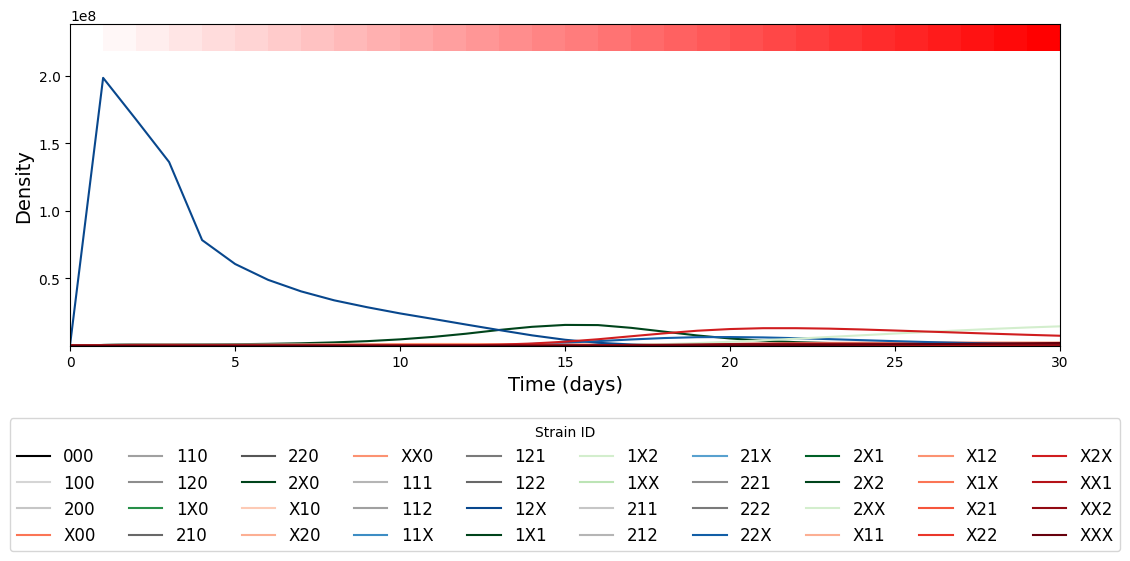

Exporting /content/drive/MyDrive/SYNC_Projects/MI/figures/X_aacA37_smr1/X_aacA37_smr1_clonal_Ramp_final_density_bar.pdf


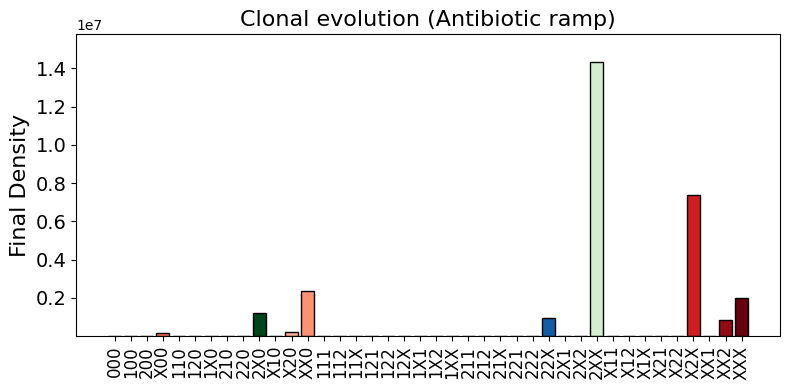

In [9]:


# Define initial populations for each strain
initial_populations = np.array([0] * len(strains_accessible))
genotype_to_find = initial_genotype_label
index_of_genotype = labels_genotypes_accessible.index(genotype_to_find) if genotype_to_find in labels_genotypes_accessible else None
initial_populations[index_of_genotype]=B0

results_ramp = runSimulationVaryingEnvironment(
    M=M_accessible, strains=strains_accessible,
    initial_populations=initial_populations, num_days=num_days,
    antibiotic_concentrations=antibiotic_ramp, initial_resource=initial_resource,
    simulation_time=simulation_time, dilution=dilution_factor, transition_rate=transition_rate, dt=0.1,
    p_sos_min=0.1, c_sos=0.5, k_sos=10.0, max_antibiotic_concentration=max_antibiotic_concentration, verbose=False
)

# Analyze results
for result in results_ramp:
    print(f"Day {result['day']}, Antibiotic: {result['antibiotic_concentration']}, Final Resource: {result['resource']}")

# Combine strain IDs with their final population densities
initial_strain_populations = [(strain['strainID'], density) for strain, density in zip(strains_accessible, initial_populations)]
initial_sorted_strains = sorted(initial_strain_populations, key=lambda x: x[1], reverse=True)[:5]
for strain_id, density in initial_sorted_strains:
    if density>0:
        print(f"Strain ID: {strain_id}, Initial Density: {density}")
print(" ")

# Combine strain IDs with their final population densities
final_strain_populations = [(strain['strainID'], density) for strain, density in zip(strains_accessible, results_ramp[-1]['final_populations'])]
final_sorted_strains = sorted(final_strain_populations, key=lambda x: x[1], reverse=True)[:5]
for strain_id, density in final_sorted_strains:
    if density>0:
        print(f"Strain ID: {strain_id}, Final Density: {density}")


outPath='%s_clonal_Ramp'%(file_name_figures)
plotPopulationDynamicsWithDrug(results_ramp, days=range(1, num_days + 1), strains=strains_accessible, initial_populations=initial_populations, max_antibiotic_concentration=max_antibiotic_concentration, antibiotic_regime=antibiotic_ramp, ncol=10, outPath=outPath)


plotFinalDensityBar(results_ramp, labels_genotypes_accessible, strains_accessible, title='Clonal evolution (Antibiotic ramp)', outPath=outPath)

### Evolutionary Simulations in Periodic Environments

This analysis explores the evolutionary dynamics of bacterial populations in environments with periodic antibiotic exposure. The simulation alternates between days with and without antibiotic pressure, creating a fluctuating selective environment. A single genotype is initialized with a predefined population density, and the dynamics of the accessible genotypes are tracked over multiple days.


In [10]:
def generate_periodic_antibiotics(num_days, max_antibiotic_concentration, period=2):
    """
    Generates a periodic antibiotic treatment, switching between N days with drug and N days without drug.

    Parameters:
        num_days (int): Number of days over which the treatment is defined.
        max_antibiotic_concentration (float): Maximum antibiotic concentration.
        period (int): Number of consecutive days with drug or without drug.

    Returns:
        list: Periodic antibiotic concentrations.
    """
    treatment = []
    on_drug = True  # Start with the drug applied
    while len(treatment) < num_days:
        # Add `period` days of drug or no drug, ensuring it doesn't exceed `num_days`
        treatment.extend([max_antibiotic_concentration if on_drug else 0] * min(period, num_days - len(treatment)))
        on_drug = not on_drug  # Toggle the drug status
    return treatment




# Example usage
period=4
periodic_antibiotic = generate_periodic_antibiotics(num_days, max_antibiotic_concentration, period)

print(f"Periodic regime over {num_days} days: {periodic_antibiotic}")


Periodic regime over 30 days: [1.0, 1.0, 1.0, 1.0, 0, 0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0]


Day 1, Antibiotic: 1.0, Final Resource: 0.008455295000003638
Day 2, Antibiotic: 1.0, Final Resource: 0.005453414999998564
Day 3, Antibiotic: 1.0, Final Resource: 0.005669085000001396
Day 4, Antibiotic: 1.0, Final Resource: 0.0033951200000013103
Day 5, Antibiotic: 0, Final Resource: 8.566170539149501e-16
Day 6, Antibiotic: 0, Final Resource: 0
Day 7, Antibiotic: 0, Final Resource: 0
Day 8, Antibiotic: 0, Final Resource: 3.585029246361506e-16
Day 9, Antibiotic: 1.0, Final Resource: 0.0007224549999990649
Day 10, Antibiotic: 1.0, Final Resource: 0.0035473499999983033
Day 11, Antibiotic: 1.0, Final Resource: 0.0006572200000020017
Day 12, Antibiotic: 1.0, Final Resource: 0.0007388300000014957
Day 13, Antibiotic: 0, Final Resource: 0
Day 14, Antibiotic: 0, Final Resource: 3.6985638220757983e-16
Day 15, Antibiotic: 0, Final Resource: 0
Day 16, Antibiotic: 0, Final Resource: 8.317262628409434e-16
Day 17, Antibiotic: 1.0, Final Resource: 0.00012492500000034747
Day 18, Antibiotic: 1.0, Final Reso

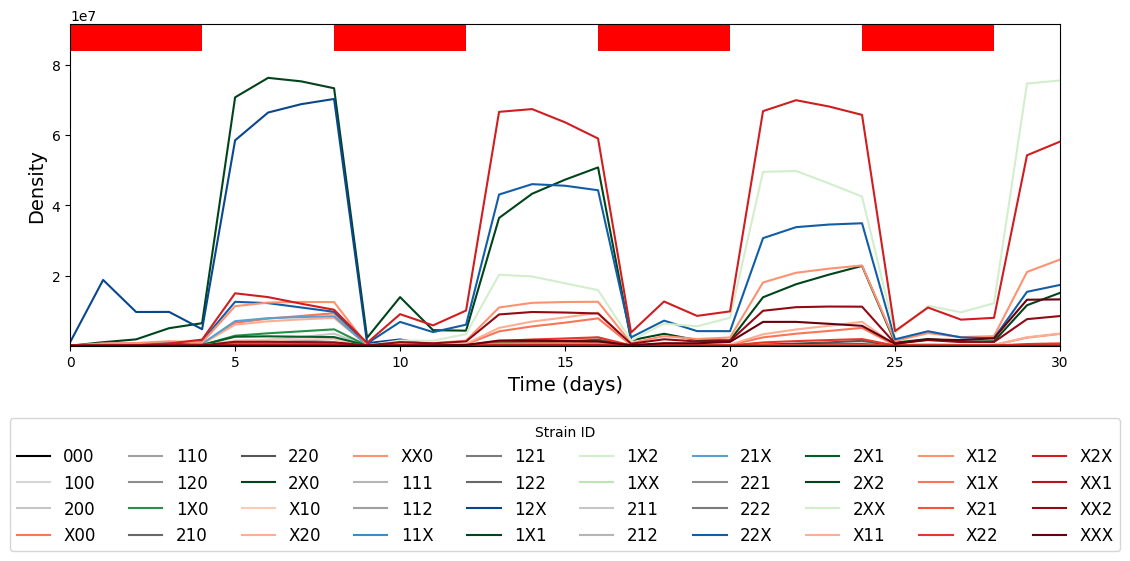

Exporting /content/drive/MyDrive/SYNC_Projects/MI/figures/X_aacA37_smr1/X_aacA37_smr1_clonal_Ramp_final_density_bar.pdf


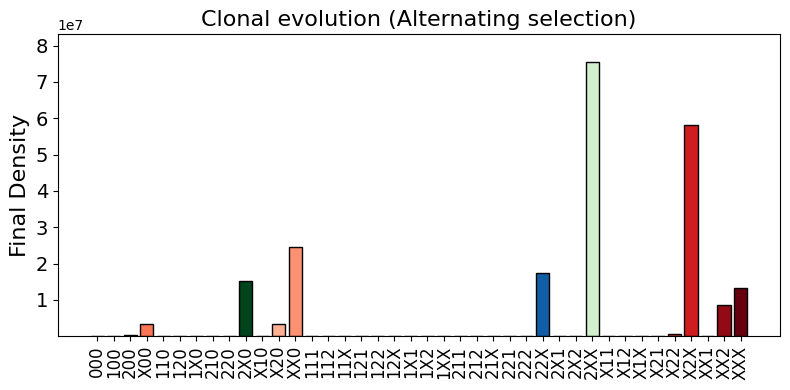

In [11]:
# Define initial populations for each strain
initial_populations = np.array([0] * len(strains_accessible))
genotype_to_find = initial_genotype_label
index_of_genotype = labels_genotypes_accessible.index(genotype_to_find) if genotype_to_find in labels_genotypes_accessible else None
initial_populations[index_of_genotype]=B0

results_fluctuating = runSimulationVaryingEnvironment(
    M=M_accessible, strains=strains_accessible,
    initial_populations=initial_populations, num_days=num_days,
    antibiotic_concentrations=periodic_antibiotic, initial_resource=initial_resource,
    simulation_time=simulation_time, dilution=dilution_factor, transition_rate=transition_rate, dt=0.1,
    p_sos_min=0.1, c_sos=0.5, k_sos=10.0, max_antibiotic_concentration=max_antibiotic_concentration, verbose=False
)

# Analyze results
for result in results_fluctuating:
    print(f"Day {result['day']}, Antibiotic: {result['antibiotic_concentration']}, Final Resource: {result['resource']}")

# Combine strain IDs with their final population densities
initial_strain_populations = [(strain['strainID'], density) for strain, density in zip(strains_accessible, initial_populations)]
initial_sorted_strains = sorted(initial_strain_populations, key=lambda x: x[1], reverse=True)[:5]
for strain_id, density in initial_sorted_strains:
    if density>0:
        print(f"Strain ID: {strain_id}, Initial Density: {density}")
print(" ")

# Combine strain IDs with their final population densities
final_strain_populations = [(strain['strainID'], density) for strain, density in zip(strains_accessible, results_fluctuating[-1]['final_populations'])]
final_sorted_strains = sorted(final_strain_populations, key=lambda x: x[1], reverse=True)[:5]
for strain_id, density in final_sorted_strains:
    if density>0:
        print(f"Strain ID: {strain_id},Ç Final Density: {density}")


outPath='%s_clonal_Ramp'%(file_name_figures)
plotPopulationDynamicsWithDrug(results_fluctuating, days=range(1, num_days + 1), strains=strains_accessible, initial_populations=initial_populations, max_antibiotic_concentration=max_antibiotic_concentration, antibiotic_regime=periodic_antibiotic, ncol=10, outPath=outPath)


plotFinalDensityBar(results_fluctuating, labels_genotypes_accessible, strains_accessible, title='Clonal evolution (Alternating selection)', outPath=outPath)